# Energy Materials: Design, Discovery and Data

## 6. Materials Theory and Simulation

![](./images/lengthscales.png)
<center>From http://www.icams.de</center>

## Advance Reading
[Challenges in Modeling Materials Properties Without Experimental Input (Science, 2008)](http://science.sciencemag.org/content/321/5890/800)

## Lecture Slides 
On [Speakerdeck](https://speakerdeck.com/aronwalsh)

In [ ]:
%%HTML 
<To embed>

## pyExample: Band Structure of Si

Adapted from https://gist.github.com/necromanteion/3987bfd8a0f38f7dff4e by W. M. Medlar, where the form of the Hamiltonian and the interaction paramaters are taken from [Chadi and Cohen (1975)](http://onlinelibrary.wiley.com/doi/10.1002/pssb.2220680140/abstract). The tight-binding method is an attractive electronic structure approach due to its simplicity. It requires only a few parameters to calculate the band structure of a crystal. This example for bulk silicon requires six empirical parameters.

In [39]:
# System setup
import sys
assert sys.version_info >= (3,4)
import numpy as np
from matplotlib import pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Define Functions

In [43]:
def phase(k, neighbors):
    '''
    Determines phase factors of overlap parameters using the assumption of
    nearest neighbor overlap
    
    args:
        k: A numpy array of shape (3,) that represents the k-point at which to
           calculate phase factors
        neighbors: A numpy array of shape (4, 3) that represents the four nearest
                   neighbors in the lattice of an atom centered at (0, 0, 0)
                   
    returns:
        A numpy array of shape (4,) containing the (complex) phase factors
    '''
    
    a, b, c, d = [np.exp(1j * k @ neighbor) for neighbor in neighbors]
    factors = np.array([
        a + b + c + d,
        a + b - c - d,
        a - b + c - d,
        a - b - c + d
    ])
    return (1 / 4) * factors

def band_energies(g, es, ep, vss, vsp, vxx, vxy):
    '''
    Calculates the band energies (eigenvalues) of a material using the
    tight-binding approximation for nearest-neighbor interactions
    
    args:
        g: A numpy array of shape (4,) representing the phase factors with respect
           to a wavevector k and the crystal's nearest neighbors
        es, ep, vss, vsp, vxx, vxy: Parameters for orbital overlap
                                interactions between nearest neighbors
                                    
    returns:
        A numpy array of shape (8,) containing the eigenvalues of the
        corresponding Hamiltonian
    '''
    
    gc = np.conjugate(g)

    hamiltonian = np.array([
        [         es,  vss * g[0],            0,            0,            0, vsp * g[1], vsp * g[2], vsp * g[3]],
        [vss * gc[0],          es, -vsp * gc[1], -vsp * gc[2], -vsp * gc[3],          0,          0,          0],
        [          0, -vsp * g[1],           ep,            0,            0, vxx * g[0], vxy * g[3], vxy * g[1]],
        [          0, -vsp * g[2],            0,           ep,            0, vxy * g[3], vxx * g[0], vxy * g[1]],
        [          0, -vsp * g[3],            0,            0,           ep, vxy * g[1], vxy * g[2], vxx * g[0]],
        [vsp * gc[1],           0,  vxx * gc[0],  vxy * gc[3],  vxy * gc[1],         ep,         0,           0],
        [vsp * gc[2],           0,  vxy * gc[3],  vxx * gc[0],  vxy * gc[2],          0,        ep,           0],
        [vsp * gc[3],           0,  vxy * gc[1],  vxy * gc[1],  vxx * gc[0],          0,         0,          ep]
    ])

    eigvals = np.linalg.eigvalsh(hamiltonian)
    eigvals.sort()
    return eigvals

def band_structure(params, neighbors, path):
    
    bands = []
    
    for k in np.vstack(path):
        g = phase(k, neighbors)
        eigvals = band_energies(g, *params)
        bands.append(eigvals)
    return np.stack(bands, axis=-1)

def linpath(a, b, n=50, endpoint=True):
    '''
    Creates an array of n equally spaced points along the path a -> b, not inclusive

    args:
        a: Starting position
        b: Ending position
        n: Integer number of sample points (defaults to 50)
        
    returns:
        A numpy array of shape (n, k) where k is the shortest length of either
        iterable -- a or b
    '''
    # list of n linear spacings between the start and end 
    spacings = [np.linspace(start, end, num=n, endpoint=endpoint) for start, end in zip(a, b)]
    
    # stacks along their last axis, transforming a list of spacings into an array of points of len n
    return np.stack(spacings, axis=-1)

### Define: Silicon (Diamond lattice)

The tight binding paramaters are taken from [Chadi and Cohen (1975)](http://onlinelibrary.wiley.com/doi/10.1002/pssb.2220680140/abstract). $E_s$ and $E_p$ are arbitrary as long as they obey $E_p - E_s = 7.20$. $E_s$ determines the zero of the energy (here the valence band maximum)


In [46]:
# Es, Ep, Vss, Vsp, Vxx, Vxy
# Ep - Es = 7.20
params = (-4.03, 3.17, -8.13, 5.88, 3.17, 7.51)

# k-points per path
n = 100

# lattice constant
a = 1

# nearest neighbors to atom at (0, 0, 0)
neighbors = a / 4 *  np.array([
    [1, 1, 1],
    [1, -1, -1],
    [-1, 1, -1],
    [-1, -1, 1]
])

# symmetry points in the Brillouin zone
#         see http://www.cryst.ehu.es/cryst/get_kvec.html 
G = 2 * np.pi / a * np.array([0, 0, 0])
L = 2 * np.pi / a * np.array([1/2, 1/2, 1/2])
K = 2 * np.pi / a * np.array([3/4, 3/4, 0])
X = 2 * np.pi / a * np.array([0, 0, 1])
W = 2 * np.pi / a * np.array([1, 1/2, 0])
U = 2 * np.pi / a * np.array([1/4, 1/4, 1])

# k-paths
lambd = linpath(L, G, n, endpoint=False)
delta = linpath(G, X, n, endpoint=False)
x_uk = linpath(X, U, n // 4, endpoint=False)
sigma = linpath(K, G, n, endpoint=True)

### Calculate Band Structure

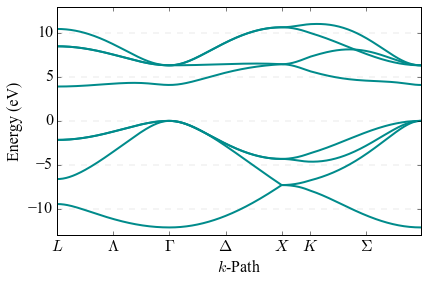

In [47]:
bands = band_structure(params, neighbors, path=[lambd, delta, x_uk, sigma])

# plot setup
plt.figure(figsize=(6,4))
fontSize = 16
mpl.rc('font', **{ 'family' : 'serif', 'size' : fontSize, 'serif' : 'Times New Roman' })
mpl.rc('lines', **{ 'linewidth' : 0.5 })
axes = plt.gca()
for spine in axes.spines.values():
    spine.set_linewidth(1.0)
plt.tight_layout()

# axis range and titles
ylim(-13,13)
plt.xlabel('$k$-Path')
plt.ylabel('Energy (eV)')

# tick labels for k-points
xticks = n * np.array([0, 0.5, 1, 1.5, 2, 2.25, 2.75, 3.25])
plt.xticks(xticks, ('$L$', '$\Lambda$', '$\Gamma$', '$\Delta$', '$X$', '$K$', '$\Sigma$', '$\Gamma$'))

# horizontal guide lines every 5 eV
for y in np.arange(-25, 25, 5):
    plt.axhline(y, ls='--', lw=0.3, color='black', alpha=0.3)

# plot the bands    
for band in bands:
    plt.plot(band, lw=2.0, color="darkcyan")

plt.show()

### Comparison to 1975 

 | $\Gamma_{25'}$ | $\Gamma_{1}$ | $\Gamma_{15}$ | $\Gamma_{2'}$ | $L_{2'}$ | $L_1$ | $L_{3'}$ | $X_1$ | $X_4$ | $\Sigma\text{(0.5, 0.5, 0)}$ | $\Sigma\text{(0.7, 0.7, 0)}$
:--- | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---:
Calculated | 0 | -12.16 | 4.10 | 4.10 | -9.49 | -6.64 | -2.17 | -7.32 | -4.34 | -3.51 | -4.25
Chadi and Cohen | 0 | -12.16 | 3.42 | 4.10 | -9.44 | -7.11 | -1.44 | -7.70 | -2.87 | -3.84 | -4.32


## Supplementary Links 

* Python Quantum Chemistry: http://pyquante.sourceforge.net
* Python Tight Binding: http://www.physics.rutgers.edu/pythtb/index.html
* GPAW: https://wiki.fysik.dtu.dk/gpaw/